In [24]:
#imports
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

import os
import pandas as pd
from datetime import date
import matplotlib as mpl
from matplotlib import pyplot as plt

from utils.basic_utils import csv_store, csv_ext, numeric_cols
from utils.pricing import dummy_col, px_fwd_ret, get_ind_index, discret_rets
from utils.pricing import rename_col
from utils.fundamental import chain_outlier
from utils.TechnicalDS import TechnicalDS
from utils.pred_utils import get_top_predictions, get_most_frequent_preds
from utils.pred_utils import get_study_date_range, stop_loss, plot_symbol_hist_pred

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.layers import BatchNormalization

mpl.rcParams['figure.figsize'] = [5.0, 3.0]
mpl.rcParams['font.size'] = 8
mpl.rcParams['legend.fontsize'] = 'medium'
mpl.rcParams['figure.titlesize'] = 'large'

In [25]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[]

### Context

In [27]:
model_dict = {
    '05-24-19': {
        'model': 'micro_TF-05-24-19.h5',
        'features': 'micro_TF_train_cols-05-24-19.npy',
        'local_pred': 'micro_pred-5-29-19-15-yrs.h5'
    },
    'bp': {
        'model': 'micro_TF-bp.h5',
        'features': 'micro_TF_train_cols-bp.npy',
        'local_pred': 'micro_pred-bp-15-yrs.h5'
    },
    'all': {
        'model': 'micro_TF-all.h5',
        'features': 'micro_TF_train_cols-all.npy',
        'local_pred': 'micro_pred-all-15-yrs.h5'
    }
}

active_model = 'all'

# context
context = {
    'ml_path': '../ML/',
    'tmp_path': '../tmp/',    
    'px_vol_ds': 'universe-px-vol-ds.h5',    
    'model_name': f'{model_dict[active_model]["model"]}',
    'trained_cols': f'{model_dict[active_model]["features"]}',
    'look_ahead': 120,
    'smooth': 1,
    'look_back': 252*15,
    'load_ds': True,
    'scale': True,
    'verbose': True,
    's3_path': 'recommend/micro_ML/',
}

#### Load dataset

In [33]:
tech_ds = TechnicalDS(
    context['tmp_path'], 
    context['px_vol_ds'], 
    load_ds=True, 
    look_ahead=context['look_ahead'], 
#     fwd_smooth=context['smooth'], 
    max_draw_on=True, 
    tickers='All',
)
y_col = tech_ds.ycol_name
tech_ds.create_base_frames()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4673 entries, 2004-06-10 to 2019-06-11
Columns: 6380 entries, (high, 0700.HK) to (volume, ^VIX)
dtypes: float32(6380)
memory usage: 113.8 MB
None
Target date: 2019-06-11
Loading file quote/csv/2019-06-11
Loading file summary-categories/defaultKeyStatistics/2019-06-11
Loading file summary-categories/financialData/2019-06-11
Loading file summary-categories/assetProfile
1199 companies
Universe sectors: 11, industries: 136
OCLHV dataframes
Inverted instruments
Change dataframes
Moving averages/52Wk percentage dataframes
Relative volume and dollar value dataframes
Realized volatility dataframe
Percentage change stds dataframes
Max draw/pull dataframes
Ranked returns dataframes
Forward return dataframe


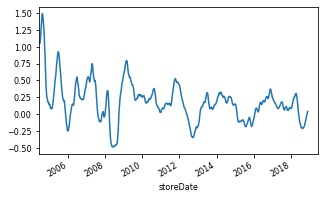

In [34]:
# default smooth
tech_ds.fwd_return_df['AAPL'].plot()

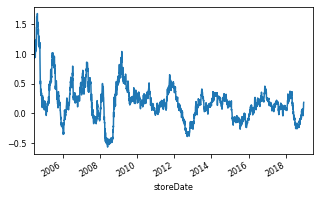

In [32]:
# 1 smooth
tech_ds.fwd_return_df['AAPL'].plot()

In [22]:
cut_range = tech_ds.return_intervals(tresholds=[0.4, 0.75])

Treshold distributions: [ -inf -0.19 -0.07  0.    0.1   0.24   inf]


In [ ]:
quotes = tech_ds.quotes
profile = tech_ds.profile
price_share = 20
min_volume_shares = 0.3e6
liquid_tickers = list(quotes.loc[
    (quotes.quoteType == 'EQUITY') &
    (quotes.regularMarketPrice > price_share) & 
    (quotes.averageDailyVolume3Month > min_volume_shares)
    , 'symbol'])
tech_ds.tickers = liquid_tickers
# quotes.loc[quotes.regularMarketPrice < 50, 'regularMarketPrice'].hist(bins=50)
# quotes.loc[quotes.v < 50, 'regularMarketPrice']
# quotes.loc[quotes.averageDailyVolume3Month > 0.3e6, 'averageDailyVolume3Month'].hist(bins=50)
labels_list = list(reversed(range(len(tech_ds.forward_return_labels))))

print(f'Liquid tickers: >${price_share} and >{min_volume_shares} shares/day: {len(liquid_tickers)}')
clean_px, labels = tech_ds.clean_px, tech_ds.forward_return_labels

#### Assumptions

In [48]:
# Key inputs
long = False # enable long or short
loss_protection = False # stop losses dont seem to help
max_loss = 0.1
holding_period = 120 # how many days to hold / rebalance
as_of_date = -holding_period
as_of_date = -1
watch_overtime = False # pick most frequent predictions within X study period
study_period = -10;
min_confidence = 0.95 # cut off
period_tresh = 0.5 # percent of time in the list during study period
nbr_positions = 10
pred_classes = labels_list[:2] if long else labels_list[-2:]
# pred_classes = [0, 1, 2, 3, 4] # all classes, is it a good picker?

ls_categ = "long" if long else "short"
dd_folder = './dd/'
os.makedirs(dd_folder, exist_ok=True)

look_ahead = context['look_ahead']
look_back = context['look_back']
tmp_path = context['tmp_path']

#### Predict

In [ ]:
def pre_process_ds(context):
    raw_df = tech_ds.stitch_companies_groups()
    print(f'Shape excluding NAs: {raw_df.shape}')
    symbols = raw_df.reset_index().set_index(['symbol']).index
    sector_map = tech_ds.profile.loc[tech_ds.tickers,'sector'].to_dict()
    raw_df.loc[:, 'sector'] = symbols.map(sector_map)
    raw_df = chain_outlier(raw_df, None)
    # basic impute and scaling
    scale_on = context['scale']
    scaler = StandardScaler()
    num_cols = numeric_cols(raw_df)
    if scale_on: raw_df.loc[:, num_cols] = scaler.fit_transform(
        raw_df[num_cols])
    # add categoricals
    raw_df.dropna(subset=['sector'], inplace=True)
    raw_df = dummy_col(raw_df, 'sector', shorten=True)
    return raw_df

In [ ]:
def predict_ds(context):
    
    ml_path = context['ml_path']
    model_name = context['model_name']
    trained_cols = context['trained_cols']
    look_back = context['look_back']

    joined_df = pre_process_ds(context)
    joined_df.reset_index(level=1, inplace=True)
    pred_X = joined_df.loc[joined_df.sort_index().index.unique()[-look_back:], :]
    print('pred_X.shape', pred_X.shape)

    # ensure prediction dataset is consistent with trained model
    # save feature order
    train_cols = np.load(ml_path + trained_cols, allow_pickle=True)
    missing_cols = [x for x in train_cols if x not in pred_X.columns]
    if len(missing_cols):
        print(f'Warning missing columns: {missing_cols}')
        for c in missing_cols:
            pred_X[c] = 0

    sorted_cols = list(np.append(train_cols, ['symbol']))
    print('pred_X.shape', pred_X[sorted_cols].shape)

    pred_df = pd.DataFrame()
    pred_df['symbol'] = pred_X.symbol

    # Load model
    fname = ml_path + model_name
    model = load_model(fname)
    print('Loaded', fname)

    preds = model.predict(pred_X[sorted_cols].iloc[:, :-1])
    preds_classes = model.predict_classes(pred_X[sorted_cols].iloc[:, :-1])

    labels = tech_ds.forward_return_labels
    pred_df['pred_class'] = preds_classes
    pred_df['pred_label'] = list(map(lambda x: labels[x], preds_classes))
    probs = np.round(preds, 3)
    # higest prob
    pred_df['confidence'] = [x[np.argmax(x)] for x in probs]
    prob_df = pd.DataFrame(probs, index=pred_df.index, columns=labels)
    pred_df = pd.concat([pred_df, prob_df[labels]], axis=1)
    pred_df.index.name = 'pred_date'

#     # store in S3
#     s3_path = context['s3_path']
#     s3_df = pred_df.reset_index(drop=False)
#     rename_col(s3_df, 'index', 'pred_date')
#     csv_store(s3_df, s3_path, csv_ext.format(tech_ds.tgt_date))

    return pred_df

In [ ]:
%%time 
# predict for all
pred_df = predict_ds(context)

#### Long-Term Experiment Predictions

In [ ]:
lt_exp_fname = f'{model_dict[active_model]["local_pred"]}'

In [ ]:
# CAREFUL IT OVERRIDES LOCAL FILE
pred_df.to_hdf(tmp_path + lt_exp_fname, key='micro_pred')

In [ ]:
pred_df = pd.read_hdf(tmp_path + lt_exp_fname)
pred_df = pred_df.loc[
    pred_df.symbol.isin(liquid_tickers) &
    pred_df.confidence > min_confidence
]
pred_df.info()

#### Today's predictions

In [ ]:
%%time
# read from S3
from utils.basic_utils import csv_load
s3_path = context['s3_path']
pred_df = pd.read_csv(
    csv_load(f'{s3_path}{tech_ds.tgt_date}'), 
    index_col='pred_date', parse_dates=True)
pred_df.info()

In [ ]:
pred_df.tail()

#### Visualize one company

In [ ]:
# recommendation distribution
print('Prediction distribution')
pd.value_counts(pred_df.pred_label) / pd.value_counts(pred_df.pred_label).sum()

In [ ]:
symbol = np.random.choice(tech_ds.tickers)
print(f'Active symbol: {symbol}')

In [ ]:
plot_symbol_hist_pred(symbol, clean_px, context, pred_df, labels)

plt.savefig(f'./dd/{symbol}-pred-chart.png', 
            bbox_inches='tight',
            dpi=200)

In [ ]:
pred_df.loc[pred_df.symbol.isin([symbol])].tail(10)

### AI portfolio -- one period

In [ ]:
# pred_df.loc[pred_df.pred_class.isin(pred_classes)].sort_values(by='confidence', ascending=False)

In [ ]:
top_pred = get_top_predictions(pred_df, as_of_date, pred_classes, min_confidence)
top_pred.head()

In [ ]:
study_dates = get_study_date_range(pred_df, as_of_date, study_period)
study_dates

In [ ]:
most_freq_df = get_most_frequent_preds(
    pred_df, study_dates, top_pred, 
    pred_classes, period_tresh)

if watch_overtime: top_pos = most_freq_df.head(nbr_positions)
else: top_pos = top_pred.loc[
        top_pred.pred_class.isin(pred_classes) & 
        top_pred.confidence > min_confidence].head(nbr_positions)

symbols = list(top_pos.symbol)
print(f'{len(symbols)} {"LONG" if long else "SHORT"} Symbols, {symbols}')
top_pred.loc[top_pred.symbol.isin(symbols)]

#### Share allocation

In [ ]:
amount = 800000/6

show_cols = ['shortName', 'regularMarketPrice', 'averageDailyVolume3Month', 'marketCap']
quote_alloc = quotes.loc[symbols, show_cols]
show_cols = ['sector', 'industry']
profile_alloc = profile.loc[symbols, show_cols]

allocation = amount * (1 if long else -1) / len(symbols)
alloc_df = (allocation / quotes.loc[symbols, ['regularMarketPrice']]).round(0)
# alloc_df.columns = ['shares']
alloc_df['dollarValue'] = alloc_df * quotes.loc[symbols, ['regularMarketPrice']]
alloc_df.columns = ['shares', 'dollarValue']
alloc_df = pd.concat([alloc_df, quote_alloc, profile_alloc], axis=1)
alloc_df.to_csv(f'{"long" if long else "short"}-{str(date.today())}.csv')
alloc_df

In [ ]:
# index for predictions
get_ind_index(clean_px[symbols], tail=252, name='^PORT')['^PORT'].plot(
    title='Historical Performance of Portfolio'
);

#### Descriptive stats

In [ ]:
# Distribution by sector
by_sect = tech_ds.profile.loc[symbols].groupby(by=['sector']).count().iloc[:,0].sort_values()
(by_sect / by_sect.sum()).plot.barh(title='Distribution by sector');

In [ ]:
# Distribution by industry
by_ind = tech_ds.profile.loc[symbols].groupby(by=['sector', 'industry']).count().iloc[:,0]
by_ind

In [ ]:
# Most consistent predictions
if watch_overtime:
    port_selection = top_pos.sort_values(
        by=[('confidence', 'count'), ('confidence', 'mean')], 
        ascending=False)
else: port_selection = top_pos

In [ ]:
# loss protection if enabled
idx = tech_ds.clean_px.index.get_loc(study_dates[-1])
prices = tech_ds.clean_px.iloc[idx:idx+holding_period][symbols]
port_index = get_ind_index(prices, tail=holding_period, name='PORT')

if loss_protection:
    port_index = port_index.iloc[:,:-1].apply(stop_loss, args=(long, max_loss)) # stop loss treatment
    port_index = get_ind_index(port_index, tail=holding_period, name='PORT') # recalc portfolio return

print(f'Showing returns from {tech_ds.clean_px.iloc[idx:idx+holding_period].index[[0,-1]]}')
print(f'Portfolio shape: {port_index.shape}')
port_index.plot(
    title=f'{nbr_positions} Positions Performance over {holding_period} days', 
    alpha=0.5,
    legend=False);

In [ ]:
net_return = (port_index.iloc[-1, :-1] - 1)
hit_mask = net_return>0 if long else net_return<0
hit_rate = net_return.where(hit_mask).count() / net_return.count()
print(f'Hit Rate: {round(hit_rate*100, 1)}%')
net_return.sort_values().plot.bar(title='Cumulative Return', grid=True); plt.show()
net_return.plot.hist(bins=40, grid=True);

In [ ]:
# cumulative returns for a given portfolio
max_d = round(TechnicalDS.max_draw(port_index.iloc[:, -1]), 2)
max_p = round(TechnicalDS.max_pull(port_index.iloc[:, -1]), 2)

port_index.iloc[:, -1].plot(
    title=f'PORT {holding_period} day, MaxDraw: {max_d}, MaxPull: {max_p}');

In [ ]:
# cumulative returns for a given portfolio
port_index.iloc[-1, :-1].describe()

In [ ]:
print(port_index.shape)
port_index.tail()

### AI portfolios -- multiple periods

In [ ]:
nbr_experiments = 500
describe_list = []; symbol_list = []; port_beg = []; port_end = []
profile, quotes = tech_ds.profile, tech_ds.quotes

In [ ]:
# if running both long and short do nor re-run the indices to keep the same periods
mean_ret = pd.DataFrame()
pred_period_range = range(-study_period, pred_df.index.unique().shape[0] - holding_period)
start = np.random.choice(pred_period_range, size=1)
asofs_idx = np.unique([x for x in np.random.choice(pred_period_range, size=nbr_experiments)]) #random
# asofs_idx = [x for x in pred_period_range[:nbr_experiments]] # sequential
print(f'{len(asofs_idx)} Experiments')

In [ ]:
%%time

# What are the best portfolios and how do they perform?
for i, as_of_date in enumerate(asofs_idx):

    top_pred = get_top_predictions(pred_df, as_of_date, pred_classes, min_confidence)
    study_dates = get_study_date_range(pred_df, as_of_date, study_period)
    idx = tech_ds.clean_px.index.get_loc(study_dates[-1])

    if watch_overtime:    
        most_freq_df = get_most_frequent_preds(
            pred_df, study_dates, top_pred, pred_classes, period_tresh)
        top_pos = most_freq_df.head(nbr_positions)
    else:
        top_pos = top_pred.loc[
            top_pred.pred_class.isin(pred_classes) & 
            top_pred.confidence > min_confidence]\
            .head(nbr_positions)
    
    symbols = list(top_pos.symbol)

    if len(symbols) > 5:
        prices = tech_ds.clean_px.iloc[idx:idx+holding_period][symbols]
        port_index = get_ind_index(prices, tail=holding_period, name='PORT')
        
        if loss_protection:
            port_index = port_index.iloc[:,:-1].apply(stop_loss, args=(long, max_loss)) # stop loss treatment
            port_index = get_ind_index(port_index, tail=holding_period, name='PORT') # recalc portfolio return
        # print(f'Showing returns from {clean_co_px.iloc[idx:idx+holding_period].index[[0,-1]]}')
        
        net_return = (port_index.iloc[-1, :-1] - 1)
        hit_mask = net_return>0 if long else net_return<0
        hit_rate = net_return.where(hit_mask).count() / net_return.count()
        
        pos_beg = port_index.iloc[0, :-1]
        pos_end = port_index.iloc[-1, :-1]
        max_d = round(TechnicalDS.max_draw(port_index.iloc[:, -1]), 2)
        max_p = round(TechnicalDS.max_pull(port_index.iloc[:, -1]), 2)
        
        exp_describe = pos_end.describe()
        exp_describe['max_draw'] = max_d
        exp_describe['max_pull'] = max_p
        exp_describe['hit_rate'] = hit_rate                
        exp_describe['predicted_on'] = str(study_dates[-1])
        exp_describe['measured_on'] = str(port_index.index[-1])
        exp_describe['offset_start'] = as_of_date
        exp_describe['study_period'] = study_period
        
        port_beg.append(pos_beg)
        port_end.append(pos_end)
        symbol_list.append(symbols)
        describe_list.append(exp_describe)
    print(f'#{i+1}, {study_dates[-1].strftime("%Y-%m-%d")}')
    
portfolio_sel = pd.concat(port_beg, axis=1, sort=False).T
position_perf = pd.concat(port_end, axis=1, sort=False).T
hist_ports = pd.concat(describe_list, axis=1, sort=False).T
hist_ports = hist_ports.infer_objects()


sub1_cols = ['mean','min','25%','50%','75%', 'max']
hist_ports[sub1_cols] = hist_ports[sub1_cols] - 1
hist_ports['sharpe'] = np.abs(hist_ports['mean']) / hist_ports['std']
col_order = [
    'count','mean','std','sharpe','max_draw','max_pull','hit_rate',
    'min','25%','50%','75%','max',
    'predicted_on','measured_on','offset_start','study_period']
hist_ports = hist_ports[col_order]

In [ ]:
print(f'Summary for {len(asofs_idx)} unique {"LONG" if long else "SHORT"} experiments')
print(f'{len(position_perf.columns.unique())} unique symbols (from different portfolios)')

In [ ]:
show_cols = [
    'mean','sharpe','max_draw','max_pull',
    'min','25%','50%','75%','max','std','hit_rate', 
    'predicted_on','measured_on']

# mean	sharpe	max_draw	max_pull	min	25%	50%	75%	max	std	hit_rate

# full backtest details
df = hist_ports[show_cols]
fname = f'{dd_folder}{ls_categ}-detail.csv'
df.to_csv(fname)

# summary of risk metrics
df = hist_ports[show_cols].describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99])
fname = f'{dd_folder}{ls_categ}-summary-metrics.csv'
df.to_csv(fname)

In [ ]:
# trend
show_cols = ['mean', 'std', 'sharpe', 'max_draw', 'max_pull']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3), sharey=False)
# hist_ports[show_cols].plot.line(
#     subplots=True, 
#     layout=(1, len(show_cols)),
#     figsize=(15, 3),
#     grid=True,
# #     secondary_y='sharpe',
#     title=f'{str.upper(ls_categ)} Risk Metrics Trend')
# plt.subplots_adjust(wspace=0.3)

hist_ports[['mean', 'std']].plot.line(
    grid=True, ylim=(-0.5,0.5), alpha=0.75,
    title=f'{str.upper(ls_categ)} Portfolios', 
    ax=axes[0]);
hist_ports['sharpe'].plot.line(
    grid=True, ylim=(0,3),
    title=f'{str.upper(ls_categ)} Sharpe', ax=axes[1]);
hist_ports[['max_draw', 'max_pull']].plot.area(
    grid=True, ylim=(-0.6,0.6), alpha=0.5, stacked=False,
    title=f'{str.upper(ls_categ)} Max Draw/Pull', ax=axes[2]);

plt.savefig(f'./dd/{ls_categ}-trend.png', 
            bbox_inches='tight',
            dpi=200)

In [ ]:
# histograms

# mean/std -> xlim=(-0.5,1)
# sharpe -> xlim=(0,3)
# Max draw/pull -> xlim=(-0.5,1)

# mean/std -> ylim=(0,100)
# sharpe -> ylim=(0,40)
# Max draw/pull -> ylim=(0,200)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3), sharey=False)
plt.subplots_adjust(hspace=.5)
# hist_ports.hist(column=show_cols, bins=50, layout=(1,len(show_cols)), ax=axes);
hist_ports[['mean', 'std']].plot.hist(
    bins=50, alpha=0.5, grid=True, 
    xlim=(-0.5, 1), ylim=(0,100),
    title=f'{str.upper(ls_categ)} Portfolios', 
    ax=axes[0]);
hist_ports['sharpe'].plot.hist(
    bins=50, grid=True, 
    xlim=(0, 3), ylim=(0,40),
    title=f'{str.upper(ls_categ)} Sharpe', ax=axes[1]);
hist_ports[['max_draw', 'max_pull']].plot.hist(
    bins=50, alpha=0.5, grid=True, 
    xlim=(-0.5, 1), ylim=(0,200),
    title=f'{str.upper(ls_categ)} Max Draw/Pull', ax=axes[2]);
plt.savefig(f'./dd/{ls_categ}-histogram.png', 
            bbox_inches='tight',
            dpi=200)

In [ ]:
# historical performance chart
l_w = 0.7
bench = '^GSPC'

if long: mean_ret['LONG'] = hist_ports['mean'].copy()
elif not long: mean_ret['SHORT'] = hist_ports['mean'].copy()

if 'LONG' in mean_ret.columns and 'SHORT' in mean_ret.columns:
    mean_ret['L+S'] = (mean_ret['LONG']) * l_w - (mean_ret['SHORT']) * (1-l_w)
    from_dt, to_dt = list(mean_ret.index[[0,-1]])
    from_dt = from_dt.strftime('%b %d, %Y')
    to_dt = to_dt.strftime('%b %d, %Y')
    
    SPX_df = clean_px['^GSPC']
    SPX_df = SPX_df.pct_change(look_ahead).to_frame()
    mean_ret[bench] = SPX_df.loc[mean_ret.index.unique()]
    
    ax = mean_ret.plot.area(
        title=f'{mean_ret.shape[0]} runs from {from_dt} to {to_dt}; {holding_period} day returns L={l_w*100}/S={round(1-l_w, 1)*100} vs. SPX',
        figsize=(12,4), 
        grid=True,
        stacked=False,
        ylim=(-.6, .6)
    )

    plt.savefig(f'{dd_folder}backtest.png', 
                bbox_inches='tight',
                dpi=200);

In [ ]:
# portfolio return statistics
df = mean_ret.describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99])
fname = f'{dd_folder}perf-table.csv'
df.to_csv(fname)
df

In [ ]:
from datetime import date, timedelta
show_cols = ['net_exp', bench]
if 'net_exp' in mean_ret.columns:
    df = mean_ret[show_cols].copy()
    df.index = pd.to_datetime(df.index.date - timedelta(holding_period))
    df['year'] = df.index.year
    df['month'] = df.index.month
    group_ret_df = df.groupby(by=['year', 'month']).mean()
    group_ret_df.plot(
        title=f'Inception Returns vs. SP500 ({len(mean_ret.index)} Iterations)',
        figsize=(10,5),
        grid=True);
    plt.savefig(f'{dd_folder}net-exposure.png', dpi=300)

#### Descriptive stats

In [ ]:
perf_col = f'{holding_period}DReturn'
pos_attribution = position_perf.mean()
uniq_pos_perf = pos_attribution.to_frame()
uniq_pos_perf.columns = [perf_col]
uniq_pos_perf['name'] = quotes.loc[uniq_pos_perf.index, ['shortName']]
uniq_pos_perf[['sector', 'industry']] = profile.reindex(index=uniq_pos_perf.index, columns=['sector', 'industry'])

In [ ]:
# top ten attribution
# top10_attrib = uniq_pos_perf.sort_values(by=perf_col, ascending=False).head()
# top10_attrib

In [ ]:
# bottom ten attribution
# uniq_pos_perf.sort_values(by=perf_col, ascending=False).tail()

In [ ]:
perf_sector = uniq_pos_perf.groupby(by=['sector']).agg(['mean', 'count'])
perf_ind = uniq_pos_perf.groupby(by=['industry']).mean().sort_values(by=perf_col) - 1

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 2))
# plt.subplots_adjust(wspace=0.5, hspace=0.5)
perf_sector[(perf_col, 'count')].sort_values().plot.bar(
    title=f'{str.upper(ls_categ)} Distribution', ax=axes[0]);
(perf_sector[(perf_col, 'mean')].sort_values() - 1).plot.bar(
    title=f'{str.upper(ls_categ)} Return Attribution', ax=axes[1]);

plt.savefig(f'{dd_folder}{ls_categ}-sector-attrib.png', 
            bbox_inches='tight',
            dpi=200)

In [ ]:
# Distribution by industry
by_ind = uniq_pos_perf.groupby(by=['sector', 'industry']).count().iloc[:,0].sort_values(ascending=False)
by_ind.head(20)

df = by_ind.head(20).to_frame()
fname = f'{dd_folder}{ls_categ}-mean_return_ind.csv'
df.to_csv(fname)

In [ ]:
fsize = (5, len(perf_ind.index) / 25 * 5)
perf_ind.plot.barh(title=f'{str.upper(ls_categ)} Return Attribution by Industry', figsize=fsize);
plt.savefig(f'./dd/{ls_categ}-ind-attrib.png', 
            bbox_inches='tight',            
            dpi=200)

In [ ]:
mkt_cap_cuts = [0, 0.3, 2, 10, 300, 5000]
mkt_cap_labels = ['micro', 'small', 'mid', 'large', 'mega']

In [ ]:
unique_symbols = list(uniq_pos_perf.index.unique())
size_df = tech_ds.quotes.loc[unique_symbols, ['marketCap']] / 10**9
size_df['size'] = discret_rets(size_df.marketCap, mkt_cap_cuts, mkt_cap_labels)
size_df.groupby(by=['size']).count().iloc[:,0].sort_values(ascending=False).plot.bar(
    title=f'{str.upper(ls_categ)} Distribution by size');

plt.savefig(f'./dd/{ls_categ}-by-size.png', 
            bbox_inches='tight',            
            dpi=200)

#### Most frequent

In [ ]:
# Most common recommendations with realized performance
most_frequent = position_perf.count(axis=0).sort_values(ascending=False).head(20)
plot_df = most_frequent

lens = len(plot_df.index); cols=4; rows=lens//cols
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 12), sharex=True)
plt.subplots_adjust(wspace=0.3, hspace=0.3)

for i, t in enumerate(zip(most_frequent.index, most_frequent.values)):
    row = i // cols; col = i - cols * row
    avg_return = round((pos_attribution[t[0]]-1) * 100, 1)
    clean_px[t[0]].loc[position_perf.index].plot(
        title=f'{t[0]}, {t[1]}, {avg_return}%',
        ax=axes[row, col])
    
plt.savefig(f'./dd/{ls_categ}-most-frequent.png', 
            bbox_inches='tight',             
            dpi=200)    

In [ ]:
# how often are companies in the predictions?
# df = portfolio_sel.sort_index().where(~portfolio_sel.isna(), 0)
# percentage of the time within a 30 day period that a company is recommended
# likely_df = (df.rolling(-study_period).sum() / -study_period)

# title = f'Best time to go {"LONG" if long else "SHORT"} these companies'
# symbols = ['NFLX', 'CRM', 'BLUE', 'TSLA']
# symbols = np.random.choice(likely_df.columns, size=10)

# symbols = list(most_frequent.index)
# likely_df[symbols].plot.area(title=title, legend=False); # mix of predictions is different everyday

# most_freq = likely_df.mean().sort_values().tail(10).index # most frequent
# df[symbols].plot.area();

In [ ]:
# pct_study_period = likely_df[symbols].apply(lambda x: x.where(x>0))
# pct_study_period.mean().sort_values().plot.bar(
#     title=f'What percent of the time in {-study_period} day study period');
# pct_study_period.describe().T.describe()

#### Dollar value / liquidity

In [ ]:
exp_symbols = list(position_perf.columns.unique())

In [ ]:
liquidity_df = tech_ds.dollar_value_df[exp_symbols].describe(
    percentiles=[0.01, 0.25, 0.5, 0.75, 0.99]).mean(1).to_frame()
liquidity_df = liquidity_df.loc[liquidity_df.index[1:]] / 1e6
liquidity_df.columns = ['dollar_value']
liquidity_df.T

#### Accuracy of predictions

In [ ]:
cut_range = tech_ds.return_intervals()
pred_class_tresh = [cut_range[1], cut_range[2], 0, cut_range[3], cut_range[4]]
actual_gt_tresh = lambda x, y: x > y if x > 0 else x < y
right_direction = lambda x, y: x > 0 if x > 0 else x < 0

def hist_company_accuracy(symbol, pred_df, min_confidence, clean_px, pred_class_tresh, fn):
    co_pred = pred_df.loc[(pred_df.symbol.isin([symbol]) & pred_df.confidence > min_confidence), :]
    if len(co_pred) > 0 and t in clean_px.columns:
        fwd_return = clean_px[symbol].pct_change(look_ahead).shift(-look_ahead).loc[co_pred.index]
        if len(fwd_return.dropna()) > 0:
            pred_comparison = pd.concat([fwd_return, co_pred.pred_class.apply(lambda x: pred_class_tresh[x])], axis=1).dropna()
            count = pd.value_counts(pred_comparison.apply(lambda x: fn(x[0], x[1]), axis=1))
            return symbol, (count[True] / count.sum() if True in count else 0)

In [ ]:
symbol = 'ADBE'
hist_company_accuracy(symbol, pred_df, 0.90, clean_px, cut_range, right_direction)

In [ ]:
%%time
super_list = []
for t in np.random.choice(tech_ds.tickers, size=50):
    res = hist_company_accuracy(t, pred_df, 0.9, clean_px, cut_range, actual_gt_tresh)
    super_list.append(res)
    print(res)

In [ ]:
# of the time actual returns is in the same direction as the predicted class
unpacked = list(zip(*[x for x in super_list if x is not None]))
average_score = (pd.Series(unpacked[1], index=unpacked[0]).mean())
print(f'%0.2f percent actual returns are in the same direction as the predicted class' % average_score * 100)

In [ ]:
unpacked = list(zip(*[x for x in super_list if x is not None]))
# of the time actual returns is above the treshold for the class
average_score = (pd.Series(unpacked[1], index=unpacked[0]).mean())
print(f'%0.2f percent actual returns are in excess of predicted class (outpeform)' % average_score * 100)

#### Optimal L/S weight

In [ ]:
def calc_monthly_ret(l_w, mean_ret):
    monthly_ret = (
        (mean_ret['long']).mul(l_w) - 
        (mean_ret['short']).mul(1 - l_w))
    mix_df = monthly_ret.infer_objects().describe()
    mix_df['l'] = l_w
    mix_df['s'] = 1 - l_w
    return monthly_ret, mix_df

In [ ]:
# optimal L/S mix
super_list = []
series = np.arange(0.4, 1.2, 0.05)
if 'short' in mean_ret.columns:
    for l_w in series:
        monthly_ret, mix_df = calc_monthly_ret(l_w, mean_ret)
        super_list.append(mix_df)
#         monthly_ret.cumprod().plot()
    scenarios = pd.concat(super_list, axis=1).T
    opt_wgt = series[np.argmax(scenarios['mean'] / scenarios['std'])]
    
    # expected long-term return at optimal L/S mix
    monthly_ret, _ = calc_monthly_ret(opt_wgt, mean_ret)
#     print(f'Expected return = {round(monthly_ret.cumprod().iloc[-1] ** (1/years) - 1, 2)*100}% at {round(opt_wgt, 2)} long {round(1 - opt_wgt, 2)} short')
#     monthly_ret.cumprod().plot();

In [ ]:
scenarios[['mean', 'std']].plot(kind='scatter', x='std', y='mean')
print(f'Optimal allocation {opt_wgt, 1 - opt_wgt}')
scenarios